# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [283]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools
import helmholtz.analysis.plots

In [284]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.523385380551301


## Level 0->1 Coarsening

In [285]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.310e+00                    4.468e-01    2.925
INFO     1     7.259e-01 (0.555) [0.555]    3.426e-01    2.123 (0.725)
INFO     2     4.208e-01 (0.581) [0.568]    2.928e-01    1.447 (0.681)
INFO     3     2.668e-01 (0.635) [0.590]    2.670e-01    1.011 (0.698)
INFO     4     1.851e-01 (0.695) [0.615]    2.515e-01    0.746 (0.739)
INFO     5     1.397e-01 (0.755) [0.641]    2.409e-01    0.589 (0.789)
INFO     6     1.138e-01 (0.815) [0.668]    2.330e-01    0.496 (0.843)
INFO     7     9.689e-02 (0.852) [0.691]    2.267e-01    0.434 (0.876)
INFO     8     8.543e-02 (0.882) [0.713]    2.214e-01    0.392 (0.904)
INFO     9     7.703e-02 (0.902) [0.731]    2.169e-01    0.360 (0.921)
INFO     10    7.057e-02 (0.916) [0.748]    2.129e-01    0.336 (0.934)
INFO     11    6.545e-02 (0.927) [0.763]    2.093e-01    0.317 (0.943)
INFO     12    6.127e-02 (0.936) [0.776]    2.060e-01    0.301 (0.951)
INFO 

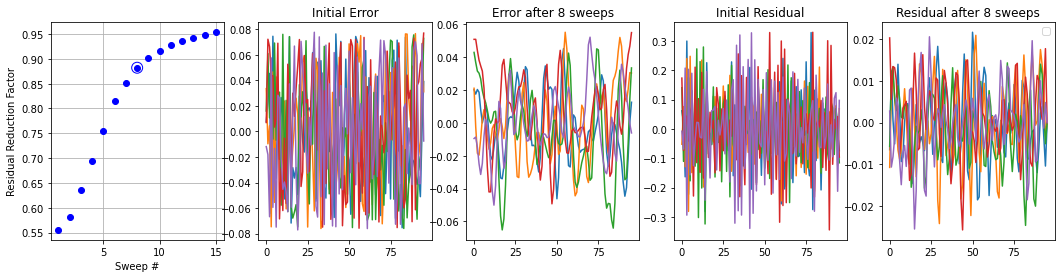

In [286]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

### Coarsening: Fixed (4/2)

In [287]:
# Generate initial test vectors.
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)

# Mock cycle rates.
mock_conv = [hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values]

# Interpolation by LS fitting. Measure 2-level rrates.
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        p = hm.setup.auto_setup.create_interpolation(
            x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, nu_coarsest=100, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + mock_conv] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=("Mock", ) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

all_conv0 = all_conv

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.106


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.5907,0.3279,0.1985,0.1442,0.1444,0.1301,0.0888,0.0643,0.0617,0.0583,0.0540
P^T A P caliber 2,0.0000,2.0000,192.0000,1.2000,0.0000,0.5266,0.4150,0.4893,0.4815,0.4872,0.4800,0.4721,0.4097,0.4685,0.3899,0.4663
P^T A P caliber 3,0.0000,3.0000,288.0000,1.4000,0.0000,0.5989,0.3410,0.3146,0.3341,0.2913,0.2895,0.2771,0.2850,0.2837,0.2736,0.2939
P^T A P caliber 4,0.0000,4.0000,384.0000,2.0000,0.0000,0.6061,0.3105,0.2021,0.1469,0.1542,0.1401,0.1134,0.1419,0.1421,0.1378,0.1356
R A P caliber 2,1.0000,2.0000,192.0000,1.2000,0.0161,0.5312,0.4434,0.4823,0.4850,0.4798,0.4752,0.4684,0.4642,0.4657,0.4663,0.4623
R A P caliber 3,1.0000,3.0000,288.0000,1.2000,0.0083,0.5966,0.3531,0.4080,0.3984,0.3675,0.3804,0.3762,0.3795,0.3753,0.3736,0.3165
R A P caliber 4,1.0000,4.0000,384.0000,1.2000,0.0035,1.1145,0.5371,0.3979,0.2174,0.1983,0.1560,0.1153,0.0849,0.0541,0.0428,0.0482


## Symmetrizing $R A P$
* First experiment: $R \rightarrow Q$, $P$ stays fixed
$A^c = QAP$ is symmetric and sparse, but not accurate since $P$ is incompatible with $Q$, so 2-level convergence not that great for some random seeds. Even the first few cycles are slow (maybe the first cycle is OK, but that's it).

In [288]:
# Fixed seed for reproducible results.
#for seed in range(100):
seed = 0
np.random.seed(seed)

# Generate initial test vectors.
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
level = multilevel[0]
x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
_LOGGER.info("Generating {} TVs with {} sweeps RER {:.3f}".format(num_examples, nu, norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

# Generate coarsening.
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)

# Generate high-caliber interpolation, 2-level hierarchy.
caliber = 4
p = hm.setup.auto_setup.create_interpolation(
    x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
    neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
    caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
level, coarse_level = m0[:2]

r = coarse_level._r
p = coarse_level._p
q = hm.repetitive.symmetry.symmetrize(r, level.a.dot(p), num_components, aggregate_size)
_LOGGER.info("|R-Q| {:.3e}".format(norm((r[:2, :4] - q[:2, :4]).todense())))

titles = ("r", "q")
restrictions = (r, q)
l2c = []
slowest_vector = []
for title, restriction in zip(titles, restrictions):
    #print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    ac = ml[1].a
    fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
    symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
    two_level_result = [
        hm.repetitive.locality.two_level_conv_factor(
            ml, nu_pre=0, nu_post=nu, nu_coarsest=100, print_frequency=None, debug=False)
         for nu in nu_values]
    two_level_conv = np.array([row[1] for row in two_level_result])
    slowest_vector.append([row[0] for row in two_level_result])
    l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))

l2c = all_conv0.loc[["Mock"]].values.tolist() + l2c
all_conv = pd.DataFrame(l2c, columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=("Mock",) + tuple(titles))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 100 sweeps RER 0.135
INFO     |R-Q| 9.466e-02


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.5907,0.3279,0.1985,0.1442,0.1444,0.1301,0.0888,0.0643,0.0617,0.0583,0.0540
r,True,4.0000,384.0000,1.2000,0.0099,1.2208,0.5302,0.3846,0.2043,0.2061,0.1597,0.1174,0.0811,0.0596,0.0384,0.0488
q,True,4.0000,384.0000,1.2000,0.0000,1.1262,0.5645,0.3928,0.1893,0.1984,0.1565,0.1202,0.0696,0.0493,0.0317,0.0295


### Slowest Component, RER reduction
All measurements (RER, plot of errors) are performed after removing the null components after each cycle. Cycles are $(0, \nu)$, so the error is measured after relaxations.

#### Two-level Cycle with exact coarse level solve

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.392e+00  (0.163)  0.688  (0.279)  4.930
INFO     2      4.090e-01  (0.121)  0.622  (0.904)  0.657
INFO     3      6.009e-02  (0.147)  0.706  (1.135)  0.085
INFO     4      1.079e-02  (0.180)  0.610  (0.864)  0.018
INFO     5      1.991e-03  (0.185)  0.612  (1.003)  0.003
INFO     6      3.886e-04  (0.195)  0.577  (0.943)  0.001
INFO     7      7.549e-05  (0.194)  0.589  (1.021)  0.000
INFO     8      1.503e-05  (0.199)  0.592  (1.004)  0.000
INFO     9      3.052e-06  (0.203)  0.601  (1.016)  0.000
INFO     10     6.489e-07  (0.213)  0.607  (1.010)  0.000
INFO     11     1.358e-07  (0.209)  0.585  (0.963)  0.000
INFO     12     2.759e-08  (0.203)  0.574  (0.981)  0.000
INFO     13     5.612e-09  (0.203)  0.580  (1.012)  0.000
INFO     14     1.149e-09  (0.205)  0.582  (1.002)  0.000
INFO     15     2.338e-10  (0.204)  0.578  (0.995)  0.000

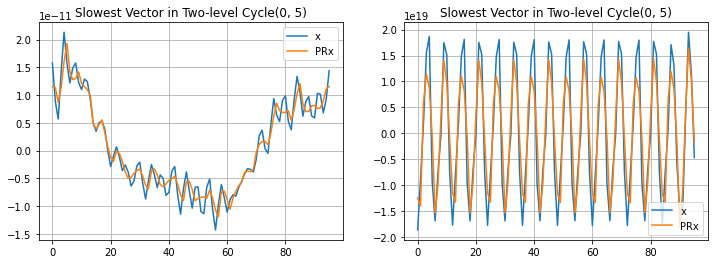

In [289]:
# Example: fixed nu.
nu = 5
nu_coarsest = -1
fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

for title, restriction, ax in zip(titles, restrictions, axs):
    print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    y, _ = hm.repetitive.locality.two_level_conv_factor(
                ml, nu_pre=0, nu_post=nu, nu_coarsest=nu_coarsest, print_frequency=1, z=z, seed=0, num_sweeps=20, debug=False, num_levels=2)
    #y -= z.dot(z.T.dot(y[:, None])).flatten()

    # Asymptotic vector.
    ax.set_title("Slowest Vector in Two-level Cycle(0, {})".format(nu))
    e = ml[1].interpolate(r.dot(y))
    ax.plot(y, label="x");
    ax.plot(e, label="PRx");
    ax.grid(True);
    ax.legend();

#### Two-level Cycle with many relaxations at coarse level

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.429e+00  (0.164)  0.690  (0.280)  4.967
INFO     2      3.923e-01  (0.114)  0.622  (0.901)  0.631
INFO     3      5.740e-02  (0.146)  0.685  (1.101)  0.084
INFO     4      9.937e-03  (0.173)  0.574  (0.838)  0.017
INFO     5      1.831e-03  (0.184)  0.600  (1.046)  0.003
INFO     6      3.614e-04  (0.197)  0.572  (0.954)  0.001
INFO     7      7.179e-05  (0.199)  0.583  (1.018)  0.000
INFO     8      1.455e-05  (0.203)  0.576  (0.989)  0.000
INFO     9      2.971e-06  (0.204)  0.580  (1.007)  0.000
INFO     10     6.289e-07  (0.212)  0.592  (1.021)  0.000
INFO     11     1.330e-07  (0.212)  0.588  (0.993)  0.000
INFO     12     2.754e-08  (0.207)  0.576  (0.979)  0.000
INFO     13     5.663e-09  (0.206)  0.574  (0.996)  0.000
INFO     14     1.161e-09  (0.205)  0.573  (0.999)  0.000
INFO     15     2.359e-10  (0.203)  0.569  (0.993)  0.000

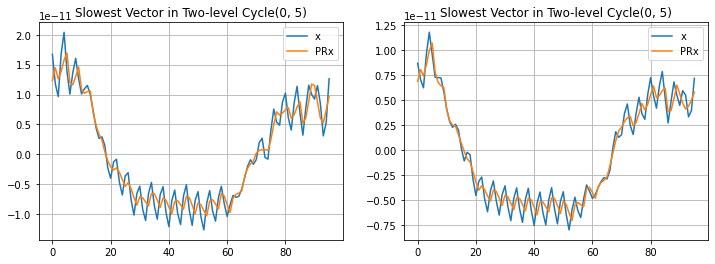

In [290]:
# Example: fixed nu.
nu = 5
nu_coarsest = 100
fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

for title, restriction, ax in zip(titles, restrictions, axs):
    print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    y, _ = hm.repetitive.locality.two_level_conv_factor(
                ml, nu_pre=0, nu_post=nu, nu_coarsest=nu_coarsest, print_frequency=1, z=z, seed=0, num_sweeps=20, debug=False, num_levels=2)
    #y -= z.dot(z.T.dot(y[:, None])).flatten()

    # Asymptotic vector.
    ax.set_title("Slowest Vector in Two-level Cycle(0, {})".format(nu))
    e = ml[1].interpolate(r.dot(y))
    ax.plot(y, label="x");
    ax.plot(e, label="PRx");
    ax.grid(True);
    ax.legend();

#### Two-level Relaxation Cycle

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.452e+00  (0.165)  0.696  (0.282)  4.959
INFO     2      4.642e-01  (0.134)  0.302  (0.434)  1.537
INFO     3      1.137e-01  (0.245)  0.112  (0.371)  1.014
INFO     4      7.538e-02  (0.663)  0.094  (0.841)  0.799
INFO     5      5.937e-02  (0.788)  0.093  (0.988)  0.637
INFO     6      4.711e-02  (0.793)  0.092  (0.992)  0.510
INFO     7      3.766e-02  (0.799)  0.092  (0.999)  0.408
INFO     8      3.010e-02  (0.799)  0.092  (0.999)  0.327
Restriction q
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.232e+00  (0.155)  0.612  (0.248)  5.278
INFO     2      4.772e-01  (0.148)  0.267  (0.436)  1.786
INFO     3      1.345e-01  (0.282)  0.109  (0.407)  1.237
INFO     4      9.420e-02  (0.700)  0.096  (0.886)  0.979
INFO     5      7.429e-02  (0.789)  0.095 

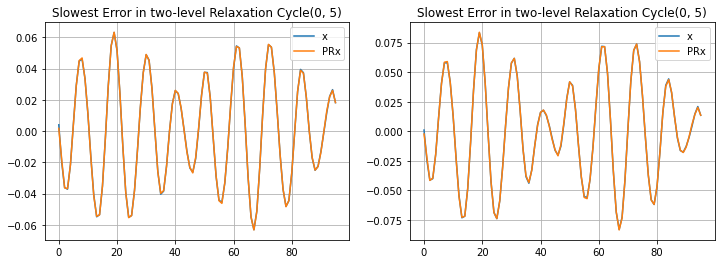

In [298]:
# Relaxation Mini-cycle (0, 5; 1).
nu = 5
nu_coarsest = 5
fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

for title, restriction, ax in zip(titles, restrictions, axs):
    print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    y, _ = hm.repetitive.locality.two_level_conv_factor(
                ml, nu_pre=0, nu_post=nu, nu_coarsest=nu_coarsest, print_frequency=1, z=z, seed=0, num_sweeps=8, debug=False, num_levels=2)
    #y -= z.dot(z.T.dot(y[:, None])).flatten()

    # Asymptotic vector.
    ax.set_title("Slowest Error in two-level Relaxation Cycle(0, {})".format(nu))
    e = ml[1].interpolate(r.dot(y))
    ax.plot(y, label="x");
    ax.plot(e, label="PRx");
    ax.grid(True);
    ax.legend();

#### Level 1 Relaxation Shrinkage

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.346e-01                    4.467e-01    0.527
INFO     1     9.882e-02 (0.423) [0.423]    2.802e-01    0.355 (0.675)
INFO     2     4.805e-02 (0.485) [0.454]    2.135e-01    0.227 (0.638)
INFO     3     3.169e-02 (0.660) [0.514]    1.856e-01    0.173 (0.761)
INFO     4     2.400e-02 (0.759) [0.566]    1.678e-01    0.144 (0.840)
INFO     5     1.946e-02 (0.809) [0.608]    1.557e-01    0.126 (0.873)
INFO     6     1.656e-02 (0.849) [0.643]    1.467e-01    0.113 (0.902)
INFO     7     1.458e-02 (0.879) [0.673]    1.395e-01    0.105 (0.925)
INFO     8     1.310e-02 (0.898) [0.698]    1.336e-01    0.099 (0.938)
INFO     9     1.195e-02 (0.911) [0.719]    1.284e-01    0.094 (0.948)
INFO     10    1.101e-02 (0.919) [0.737]    1.238e-01    0.089 (0.954)
INFO     11    1.022e-02 (0.926) [0.752]    1.198e-01    0.086 (0.958)
INFO     12    9.539e-03 (0.931) [0.766]    1.161e-01    0.083 (0.961)
INFO 

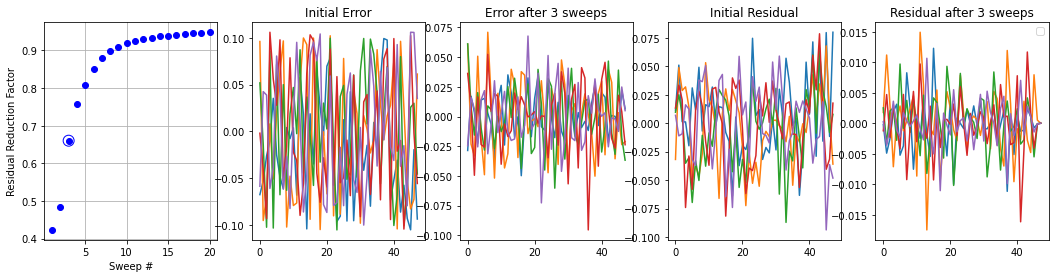

In [292]:
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

### Conclusions
* It is important to not exactly solve at the coarse level especially when null/near-null space components are present, in order to avoid inflating them due to round-off errors.
* $Q A P$ is as good as $R A P$ for different seeds.
* A two-level cycle (with many relaxations at the coarse level) does not reduce the RER more than relaxation. That's OK: again, many relaxations at the coarse level will affeect very smooth components and thus their aliasing.
* To see good shrinkage, use a relaxation mini-cycle (only several relaxations at the coarse level). Note that we only need one relaxation at the coarse level to get a good RER reduction (and indeed, Kaczmarz is a good smoother at level 1).

## Equation Interpretability
We (maybe) expect the coarse equations to be $U x_{i-1} + x_i + U^T x_{i+1}$ where $U$ is a rotation whose angle depends on $kh$.

In [293]:
# Normalized level 0 equations.
level.a.todense()[2, :5] / level.a.todense()[2,2]

matrix([[ 0.037, -0.599,  1.   , -0.599,  0.037]])

In [294]:
print("R")
display(pd.DataFrame(r[:2, :4].todense()))
print("Q")
display(pd.DataFrame(q[:2, :4].todense()))
print("P")
display(pd.DataFrame(ml[1]._p[6:10, 2:6].todense()))
print("RAP")
display(pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))
print("QAP")
qap = q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()
display(pd.DataFrame(qap))

R


,0,1,2,3
0,-0.4543,-0.5588,-0.5478,-0.4257
1,-0.6535,-0.2328,0.2562,0.6732


Q


,0,1,2,3
0,-0.4330,-0.5738,-0.5569,-0.4569
1,-0.5773,-0.2515,0.2486,0.7051


P


,0,1,2,3
0,-0.5840,0.4240,0.0849,0.1172
1,-0.3742,0.4555,-0.1071,-0.1627
2,-0.1041,0.1833,-0.3859,-0.4261
3,0.0805,-0.1276,-0.6054,-0.4030


RAP


,0,1,2,3,4,5
0,0.1501,-0.1742,-0.0321,-0.0181,0.1470,0.1587
1,0.1647,-0.1505,-0.0082,-0.6264,-0.1763,-0.1573


QAP


,0,1,2,3,4,5
0,0.1512,-0.1804,-0.0336,-0.0153,0.1512,0.1605
1,0.1605,-0.1584,-0.0153,-0.6299,-0.1804,-0.1584


In [418]:
d = qap[:, 2:4]
u = qap[:, :2]
l, v = eig(d)
#l = np.diag(np.abs(np.real(lam))**(-0.5))
#v = v.dot(l)
U = v.T.dot(u).dot(v)

In [419]:
# Off-diagonal U in U*x_{i-1} + x_i + U^T*x_{i+1} at level 1. x_i is a 2-species vector.
print("D", v.T.dot(d).dot(v))
print("U", U)

D [[-0.033 -0.   ]
 [-0.    -0.63 ]]
U [[ 0.152 -0.172]
 [ 0.168 -0.159]]


In [420]:
# U = V^{-1}*D*V
D, V = eig(U)
print(V, D)

[[0.711+0.j    0.711-0.j   ]
 [0.64 -0.291j 0.64 +0.291j]] [-0.004+0.071j -0.004-0.071j]


* The original diagonal block is already nearly diagonal.
* $U$ is nearly but not exactly anti-symmetric, as is the corresponding block before diagonalizing the central block.
What does it mean? Will it become symmetric in the limit of many coarsening levels?
* $U$ has real eigenvalues. In quantum mehcanics it's called "PT-symmetric" (space-time-reversible system). cf. https://math.stackexchange.com/questions/746223/besides-being-symmetric-when-will-a-matrix-have-only-real-eigenvalues, 
https://arxiv.org/pdf/1212.1861.pdf . This happens iff there exists a self-adjoint (symmetric positive definite here) $W$ such that $W U = U^* W$.

In [424]:
# Example of an SPD matrix that commutes with U. Any w in the range where (b - c*w)^2 < (d-a)^2 w works. We take w = b/c, 
# which means W is nothing but a diagonal scaling of U...
#w = U[0, 1] / U[1, 0]
#w12 = (U[0, 1] - U[1, 0] * w) / (U[1, 1] - U[0, 0])
#W = np.array([[1, w12], [w12, w]])
W = np.diag(np.sign(np.real(l))).dot(np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]]))
#W = np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]])

In [425]:
print("W", W, "W U", W.dot(U), "U^* T", U.T.dot(W), "diff", W.dot(U) - U.T.dot(W))

W [[-1.     0.   ]
 [ 0.    -1.024]] W U [[-0.152  0.172]
 [-0.172  0.162]] U^* T [[-0.152 -0.172]
 [ 0.172  0.162]] diff [[ 0.     0.345]
 [-0.345  0.   ]]


In [426]:
# After the full transformation - diagonalizing the central block and symmetrizing U:
print("D")
print(W.dot(v.T).dot(d).dot(v))
print("U") 
print(W.dot(v.T).dot(u).dot(v))

D
[[0.033 0.   ]
 [0.    0.645]]
U
[[-0.152  0.172]
 [-0.172  0.162]]


So this is rather trivial - one can always make the central block symmetric. If it is positive definite, $U$ can be made anti-symmetric via diagonal scaling of the equations.

### Spectral Comparison

In [523]:
# Minimum eigenvalue of A is machine 0.
lam = np.real(eig(level.a.todense())[0])
lam0 = lam[np.argsort(np.abs(lam))][:30]
print(lam0)
print("min", lam0[0])

[ 0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.205  0.205  0.235  0.235 -0.243 -0.243  0.257  0.257  0.27   0.27   0.274 -0.34  -0.34  -0.446 -0.446 -0.56  -0.56  -0.681]
min 1.1109158771219706e-16


In [533]:
# Minimum eigenvalue of RAP is non-zero.
ac = r.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam1 = lam[np.argsort(np.abs(lam))][:30]
print(lam1)
print("min", lam1[0])

[-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.153 -0.153  0.166  0.166  0.203  0.203  0.231  0.231 -0.237 -0.237  0.251  0.251  0.262  0.262  0.266 -0.319 -0.328 -0.411 -0.411 -0.497 -0.497 -0.578]
min -0.000281457032049397


In [534]:
# Minimum eigenvalue of QAP is much closer to 0.
ac = q.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam2 = lam[np.argsort(np.abs(lam))][:30]
print(lam2)
print("min", lam2[0])

[ 0.     0.     0.065  0.065 -0.073 -0.073  0.121  0.121 -0.153 -0.153  0.168  0.168  0.206  0.206  0.234  0.234 -0.237 -0.237  0.254  0.254  0.266  0.266  0.27  -0.312 -0.337 -0.413 -0.413 -0.499 -0.499 -0.58 ]
min 6.076427132065957e-06


In [535]:
# High order operator eigenvalue of P^T*A*P not close to 0 either...
ac = ml[1]._p.T.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam3 = lam[np.argsort(np.abs(lam))][:30]
print(lam3)
print("min", lam2[0])

[-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.205  0.205  0.234  0.234 -0.243 -0.243  0.255  0.255  0.267  0.267  0.271 -0.323 -0.364 -0.453 -0.453 -0.569 -0.569 -0.696]
min 6.076427132065957e-06


Another advantage of $Q A P$ is that it preserves the zero eigenvalues as well as $P^T A P$, while $RAP$ does not.

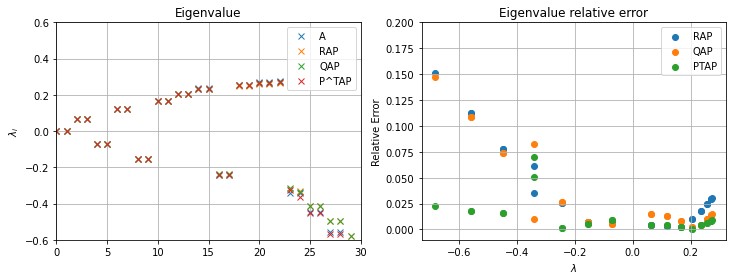

In [545]:
fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

ax = axs[0]
ax.plot(lam0, "x", label="A")
ax.plot(lam1, "x", label="RAP")
ax.plot(lam2, "x", label="QAP")
ax.plot(lam3, "x", label="P^TAP")
ax.grid(True);
ax.legend();
ax.set_xlim([0, 30]);
ax.set_ylim([-0.6, 0.6]);
ax.set_title("Eigenvalue");
ax.set_ylabel("$i$")
ax.set_ylabel("$\lambda_i$")

ax = axs[1]
ax.scatter(lam0, np.abs(lam1 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="RAP")
ax.scatter(lam0, np.abs(lam2 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="QAP")
ax.scatter(lam0, np.abs(lam3 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="PTAP")
ax.grid(True);
ax.legend();
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Relative Error")
ax.set_ylim([-0.01, 0.2]);
ax.set_title("Eigenvalue relative error");

Here we can clearly see that $QAP$ is a compromise between sparsity and accuracy: $P^T A P$ approximates many more eigenvalues accurately. It is unexpected that neither $P^T A P$ nor $R A P$ is exactly singular while $Q A P$ is (once again explaining while a direct coarse level solve is especially bad with $Q A P$).